# Bias-Variance and Ensembles
Let's do a deeper analysis of how RandomForests and Gradient Boosting reduce their prediction error. More specifically, we'll decompose the prediction error into their _bias_ and _variance_ components, and see how these are reduced by different methods: RandomForests (bagging) and GradientBoosting (boosting).

Although you can repeat this analysis with any classification dataset from OpenML, we'll use the MAGIC telescope dataset (http://www.openml.org/d/1120). The task is to classifying gamma rays: when high-energy particles hit the atmosphere, they produce chain reactions of other particles called 'showers'. These are simulated and the resulting patterns are converted into 10 numeric features. You need to detect whether these are gamma rays or background radiation.

A quick visualization of the features is shown below. Note that this is not a time series, we just plot the instances in the order they occur in the dataset. The first 12500 or so are examples of signal (gamma), the final 6700 or so are background (hadrons).

In [1]:
# General imports
%matplotlib inline
from preamble import *
plt.rcParams['figure.dpi'] = 300

In [2]:
# Download MAGIC Telescope data from OpenML. You can repeat this analysis with any other OpenML classification dataset.
magic = oml.datasets.get_dataset(1120)
X, y, attribute_names = magic.get_data(target=magic.default_target_attribute, return_attribute_names=True);

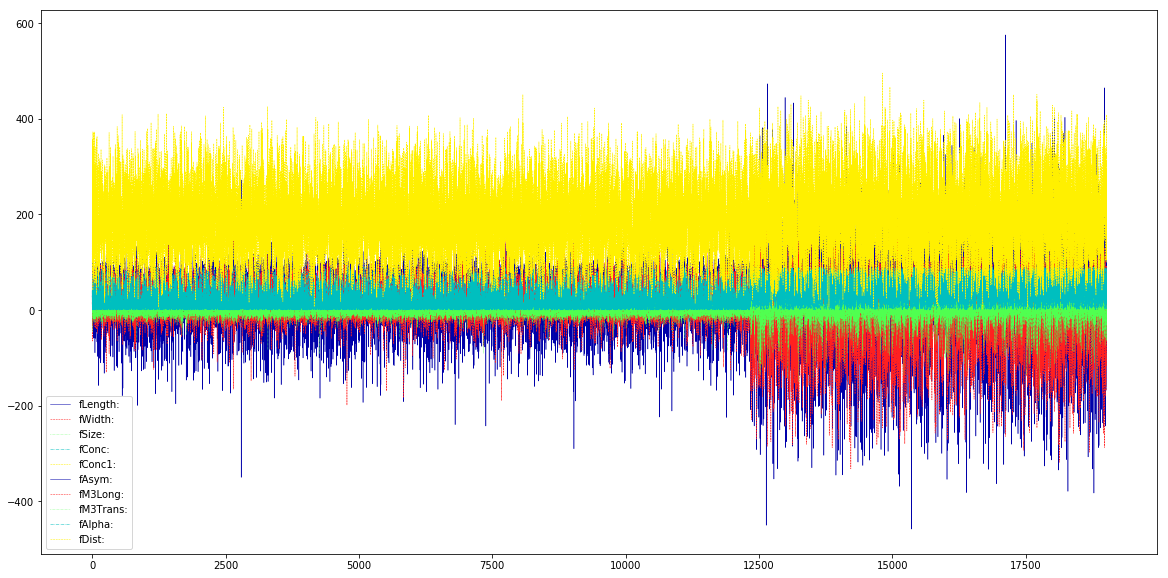

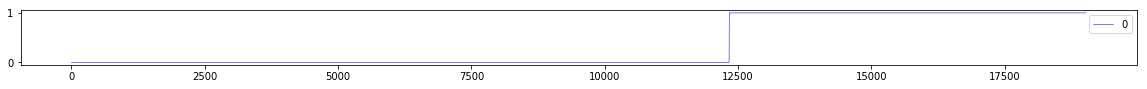

In [3]:
# Quick visualization of the features (top) and the target (bottom)
X, y, attribute_names = magic.get_data(target=magic.default_target_attribute, return_attribute_names=True)
magic = pd.DataFrame(X, columns=attribute_names)
magic.plot(figsize=(20,10))
# Also plot the target: 1 = background, 0 = gamma
pd.DataFrame(y).plot(figsize=(20,1));

## Bias-variance analysis

Here is a helper function to compute the bias-variance decomposition. It does 40 bootstraps, measures the bias, 
variance, and error in each data point, and then sums them all up:
- **Bias^2** is defined as the number of consistent misclassifications, squared. Ideally, a data point `i` is always predicted to be the true class `y[i]`, and never any of the other classes. The bias is highest if the prediction is always wrong.
- **Variance** is defined as how much variation there is in the predictions for different bootstraps. Worse case, an instance is predicted to be of one class 50% of the time, and the other class in the other 50%.
- **Error** is the total error under zero-one loss. **Error** = **Bias^2** + **Variance** (+ a small intrinsic error in the data)

Because of the random bootstraps, some data points will end up in the test set (out of bag) more often than others, so we need to keep a list of predictions for every datapoint, i.e. a list of lists `y_all_pred`, 
and weight the per-instance calculations by the number of predictions for every instance. 

Note: SKlearn doesn't support bootstrapping, so we simulate it using a 67%-33% shuffle split: each bootstrap should have about 67% of the original datapoints after sampling. 

In [11]:
from sklearn.model_selection import ShuffleSplit, train_test_split

# Bias-Variance Computation 
def compute_bias_variance(clf, X, y):
    # Bootstraps
    n_repeat = 40 # 40 is on the low side to get a good estimate. 100 is better.
    shuffle_split = ShuffleSplit(test_size=0.33, n_splits=n_repeat)

    # Store sample predictions
    y_all_pred = [[] for _ in range(len(y))]

    # Train classifier on each bootstrap and score predictions
    for i, (train_index, test_index) in enumerate(shuffle_split.split(X)):
        # Train and predict
        clf.fit(X[train_index], y[train_index])
        y_pred = clf.predict(X[test_index])

        # Store predictions
        for j,index in enumerate(test_index):
            y_all_pred[index].append(y_pred[j])

    # Compute bias, variance, error
    bias_sq = sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeat 
                for i,x in enumerate(y_all_pred)])
    var = sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat
               for i,x in enumerate(y_all_pred)])
    error = sum([ (1 - x.count(y[i])/len(x)) * len(x)/n_repeat 
            for i,x in enumerate(y_all_pred)])

    return np.sqrt(bias_sq), var, error

First, as a point of reference, we compute bias, variance, and error for a relatively large RandomForest and Gradient Boosting ensemble.

In [5]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
sh = StratifiedShuffleSplit(n_splits=10, random_state=0)

# Random Forest
rf = RandomForestClassifier(random_state=0, n_estimators=512, n_jobs=-1)
scores = cross_val_score(rf, X, y, scoring="roc_auc", cv=sh) # Calculating AUC just for fun
print("Random forest AUC: %.3f" %(scores.mean()))

# Gradient Boosting
gb = GradientBoostingClassifier(random_state=0, n_estimators=200) # Increase n_estimators if more time
scores = cross_val_score(gb, X, y, scoring="roc_auc", cv=sh)
print("Gradient boosting AUC: {:.3f}".format(scores.mean()))

# Random Forest
print("Random forest Bias: %.3f, Variance: %.3f, Error: %.3f" % (compute_bias_variance(rf, X, y)))
# Gradient Boosting
print("Gradient Boosting Bias: %.3f, Variance: %.3f, Error: %.3f" % (compute_bias_variance(gb, X, y)))

Random forest AUC: 0.938
Gradient boosting AUC: 0.930
Random forest Bias: 25.914, Variance: 82.578, Error: 754.125
Gradient Boosting Bias: 26.421, Variance: 84.447, Error: 782.525


The bias-variance results show that RandomForest and Gradient Boosting have a very similar bias-variance profile! They seem to control both bias and variance quite well (although there is also room for improvement).

## Bias, Variance, and ensemble size
We now measure the bias and error component of both algorithms for increasing numbers of trees. We vary the number of trees on a log scale from 1 to 1024, and plot the bias error (squared), variance, and total error.

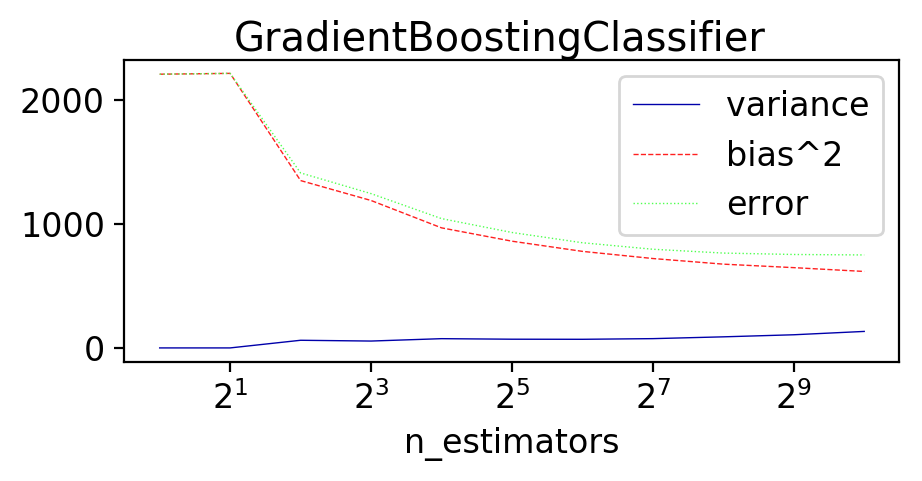

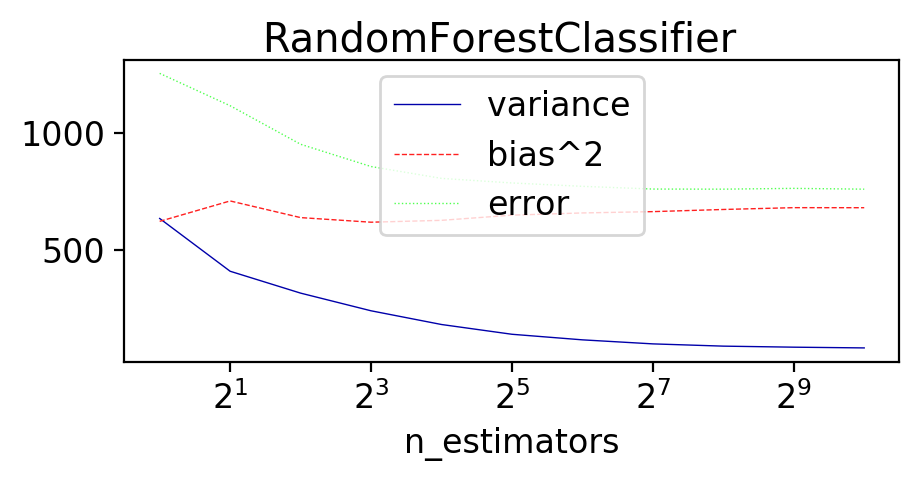

In [31]:
def plot_bias_variance(clf):
    bias_scores = []
    var_scores = []
    err_scores = []
    n_estimators= [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

    for i in n_estimators:
        b,v,e = compute_bias_variance(clf.set_params(random_state=0,n_estimators=i),X,y)
        bias_scores.append(b)
        var_scores.append(v)
        err_scores.append(e)

    plt.figure(figsize=(5,2))
    plt.rcParams.update({'font.size': 12})
    plt.suptitle(clf.__class__.__name__)
    plt.plot(n_estimators, var_scores,label ="variance" )
    plt.plot(n_estimators, np.square(bias_scores),label ="bias^2")
    plt.plot(n_estimators, err_scores,label ="error" )
    plt.xscale('log',basex=2)
    plt.xlabel("n_estimators")
    plt.legend(loc="best")
    plt.show()
    
plot_bias_variance(gb)
plot_bias_variance(rf)


Now we see that RandomForests (Bagging) and Boosting do two very different things:
- Boosting is a bias reduction technique. We can see that it reduces bias. In fact, the error goes down only because the bias component goes down. Variance actually increases a bit. This is because the 'hard' data points are misclassified by some of the models, but not all. Hence, it cannot perfectly eliminate the bias. At some point, the ensemble will start overfitting a bit.
- Bagging (RandomForest) reduces variance, and we see this in the plot. The variance is almost completely eliminated, but also note that the bias actually slightly increases. So, it also doesn't perfectly eliminate variance, at some point the ensemble will start underfitting.

## Validation curves for Gradient Boosting
For gradient boosting, we should still examine the effect of tree depth and learning rate on overall performance.

A _validation curve_ can help you understand _when_ a model starts under- or overfitting. It plots both training and test set error as you change certain hyperparameters, such as the number of estimators (trees). 

We will now build validation curves for gradient boosting, evaluated using AUROC, by varying the number of iterations between 1 and 500. In addition, we use two different values for the learning rate (e.g. 0.2 and 1), and tree depth (1 and 4).

Below is another helper function to plot. In this plot the full lines are the test set score and the dashed lines the training set score. The vertical line indicated the optimal value of the test set error.

In [4]:
from sklearn.metrics import roc_auc_score

# Plots validation curves for every classifier in clfs. 
# Also indicates the optimal result by a vertical line
# Returns 1-AUROC, so lower is better
def validation_curve(clfs, X_test, y_test, X_train, y_train):
    for n,clf in enumerate(clfs):
        test_score = np.empty(len(clf.estimators_))
        train_score = np.empty(len(clf.estimators_))

        for i, pred in enumerate(clf.staged_decision_function(X_test)):
            test_score[i] = 1-roc_auc_score(y_test, pred)

        for i, pred in enumerate(clf.staged_decision_function(X_train)):
            train_score[i] = 1-roc_auc_score(y_train, pred)

        best_iter = np.argmin(test_score)
        learn = clf.get_params()['learning_rate']
        depth = clf.get_params()['max_depth']
        test_line = plt.plot(test_score, '-',
                             label='learn=%.1f depth=%i (%.2f)'%(learn,depth,
                                                                 test_score[best_iter]))

        colour = test_line[-1].get_color()
        plt.plot(train_score, '--', color=colour)
        
        plt.xlabel("Number of boosting iterations")
        plt.ylabel("1 - area under ROC")
        plt.axvline(x=best_iter, color=colour)
        
    plt.legend(loc='best')

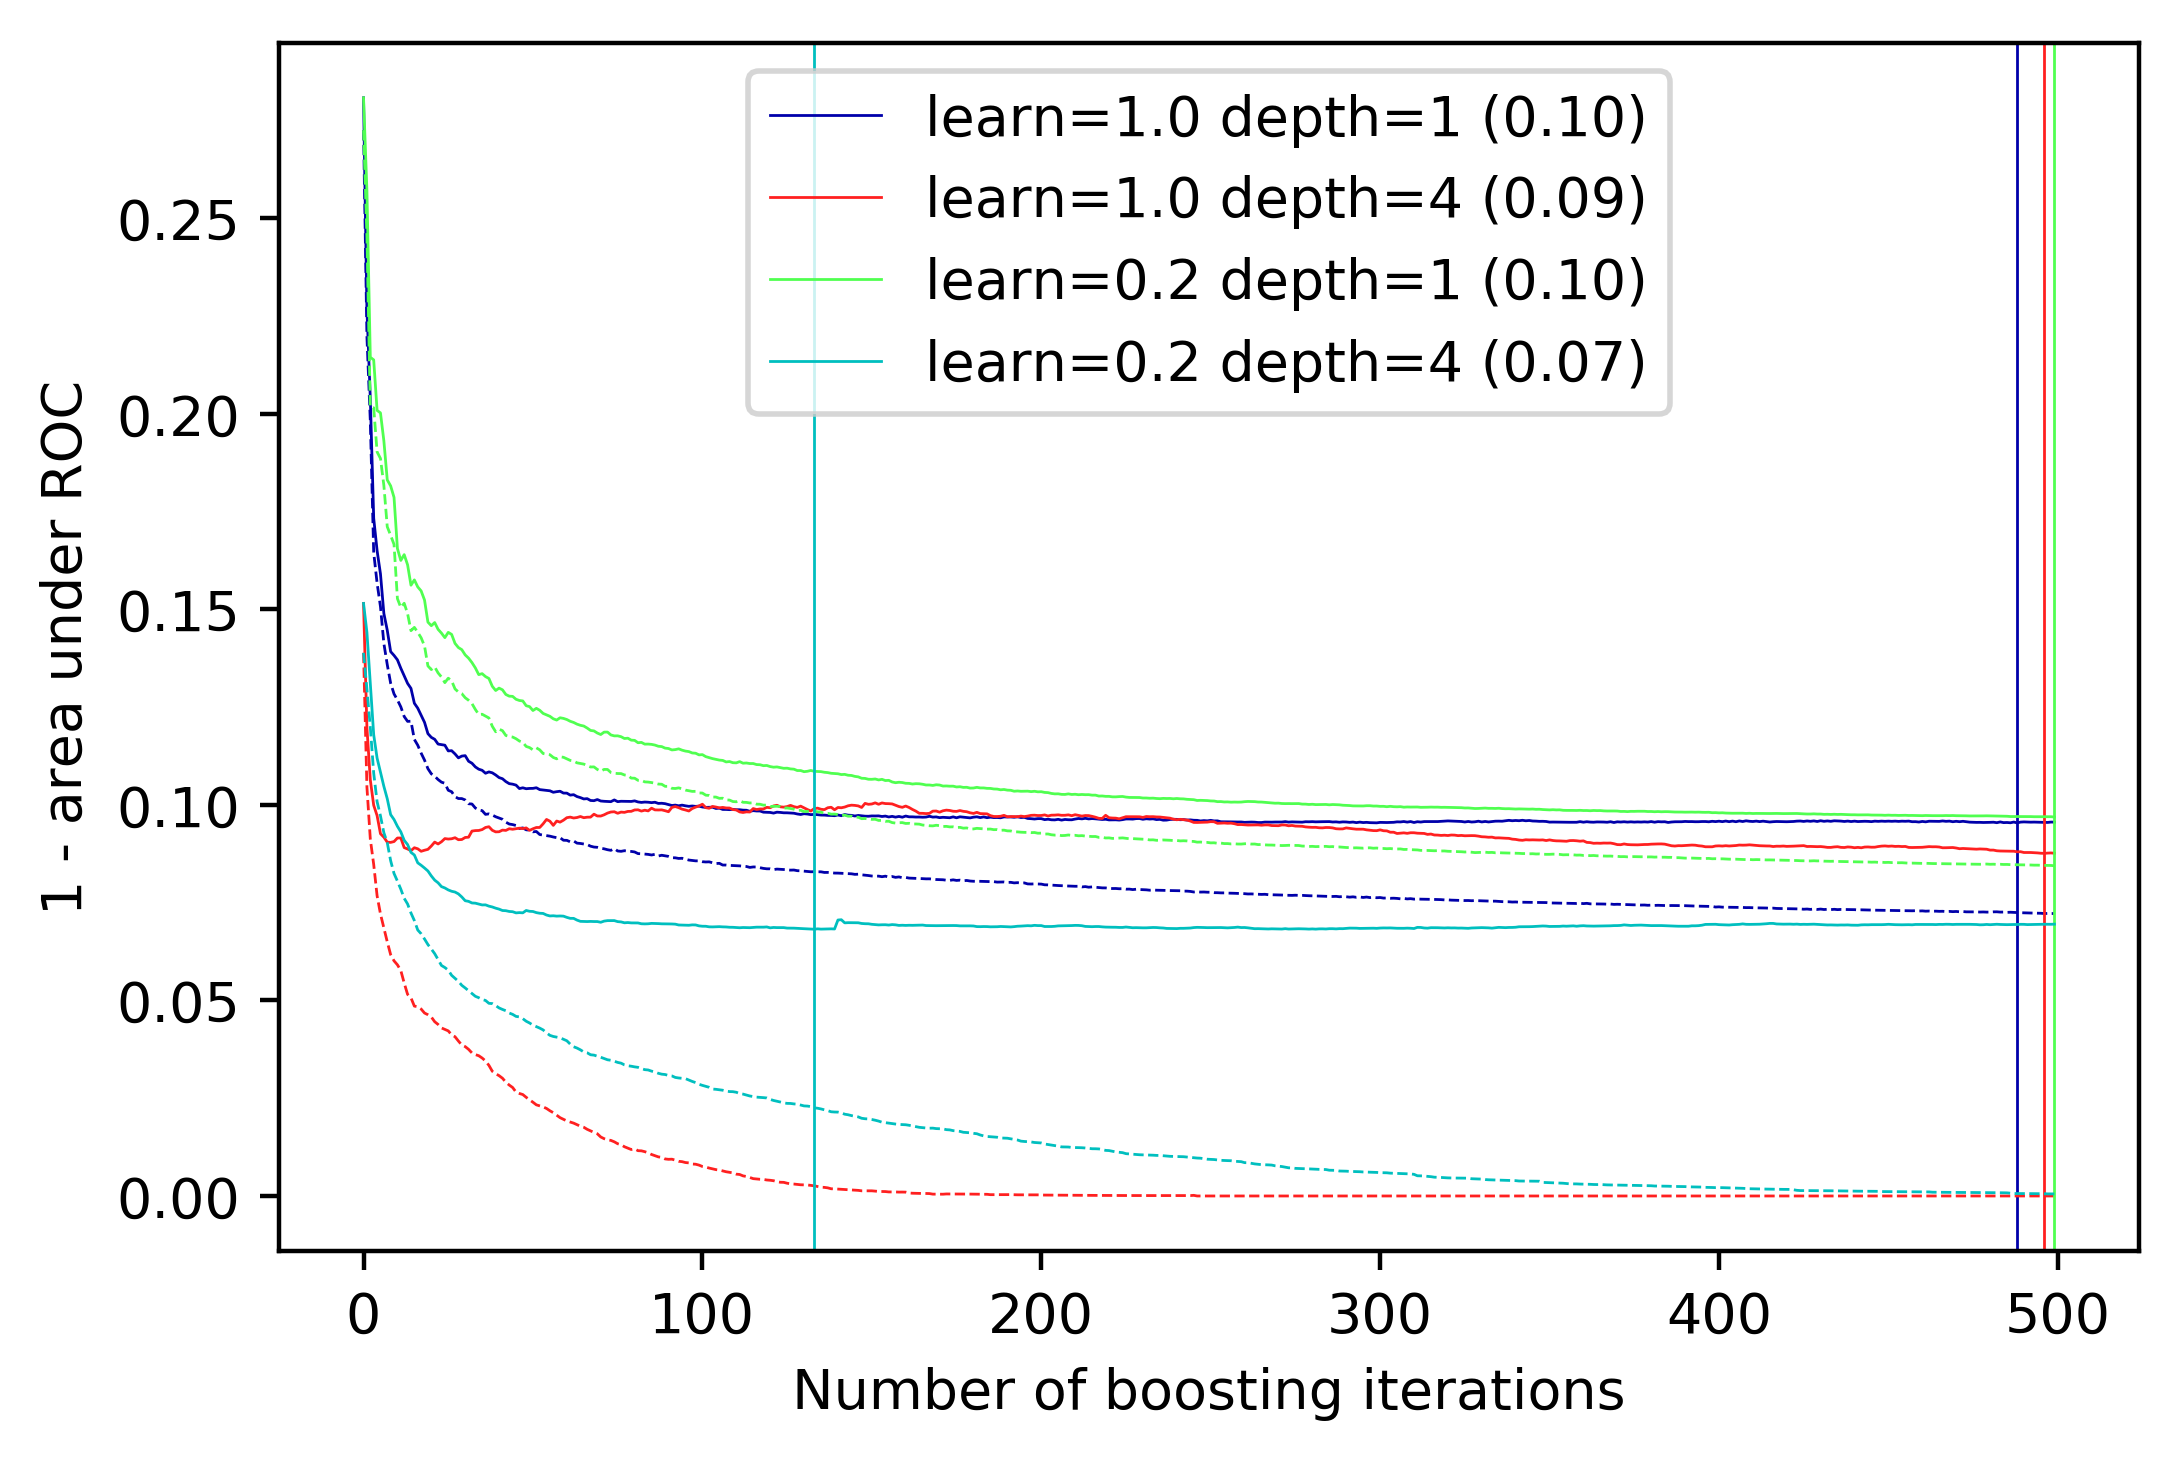

In [6]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

# Split development set into a train and test sample
plt.rcParams['figure.dpi'] = 400
X_train,X_test, y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=4685)
clfs = []
params = ((1.,1), (1.,4),
          (0.2,1), (0.2,4))

for learn,depth in params:
    gbt_clf = GradientBoostingClassifier(max_depth=depth,
                                         learning_rate=learn,
                                         n_estimators=500);
    gbt_clf.fit(X_train, y_train)
    clfs.append(gbt_clf)

validation_curve(clfs, X_test,y_test,X_train,y_train);

We plot 1-AUC, so the lower the better. 

**Tree size**:  
We clearly get worse results using very shallow trees (stumps): green and dark blue lines. Shallow trees typically have high bias and underfit a lot. While gradient boosting does reduces bias, you can only reduce bias so much, making the ensembles of decision stumps level off around 0.1. Using deeper trees means bigger variance (which boosting does NOT reduce), but overall this better fits of the data. 

**Learning rate**:  
A high learning rate means that the instance weights will get large updates, hence each individual tree will have a large impact on the next ones, and the individual trees will be more different from each other (more varied). This increases variance and the likelihood of overfitting, which can be bad for boosting since it doesn't reduce variance well. Look at the red curve: the larger learning rate reduces error faster, but then rebounds as it starts overfitting. Looking at the training set error (dashed red line, lower than any other), it indeed looks like it is overfitting. On the other hand, the smaller learning rate causes a slower optimization (weights are updated only a little bit, each individual tree will have less impact on the next, and the trees will be much more similar to each other), but it reduces the chance of overfitting and ultimately leads to the best ensemble (light blue curve). In fact, it already find it best solution after 130 iterations, while all others need 500 iterations (or more).

The best solution is thus to use slightly larger trees and a low learning rate.